In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, asin, sqrt
from sknetwork.embedding import SVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * asin(sqrt(a)) * 6371

def conformal_quantile(scores, alpha):
    n = len(scores)
    q = np.quantile(scores, np.ceil((n + 1) * (1 - alpha)) / n)
    return q

In [ ]:
def load_graph_sparse(path):
    df = pd.read_csv(path, sep='\t', header=None, usecols=[0,1], names=['u', 'v'])
    
    rows = np.concatenate([df['u'].values, df['v'].values])
    cols = np.concatenate([df['v'].values, df['u'].values])
    data = np.ones(len(rows))
    
    n_nodes = max(rows.max(), cols.max()) + 1
    
    adj = sp.csr_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    
    adj.data = np.ones_like(adj.data)
    adj.setdiag(0)
    return adj

def load_positions(path):
    if not path: return None
    df = pd.read_csv(path, sep='\t', header=None)
    pos = {}
    for _, row in df.iterrows():
        pos[row.iloc[0]] = (row.iloc[-2], row.iloc[-1]) 
    return pos

print("Data loaders ready.")


Data loaders ready.


In [ ]:
def get_node_features(adj):
    # Feature 1: Degrees
    degrees = np.array(adj.sum(axis=1)).flatten()
    
    # Feature 2: SVD Embeddings
    print("Computing SVD Embeddings (Rank 32)...")
    svd = SVD(n_components=32)
    embedding = svd.fit_transform(adj)
    
    return degrees, embedding

def compute_pair_features(pairs, degrees, embedding, pos_dict=None):
    u = pairs[:, 0]
    v = pairs[:, 1]
    
    # Feature 1-2: Node degrees
    deg_u = degrees[u]
    deg_v = degrees[v]
    
    # Feature 3: Cosine similarity of embeddings
    vec_u = embedding[u]
    vec_v = embedding[v]
    
    norm_u = np.linalg.norm(vec_u, axis=1)
    norm_v = np.linalg.norm(vec_v, axis=1)
    norm_u[norm_u == 0] = 1e-9
    norm_v[norm_v == 0] = 1e-9
    
    dot = np.sum(vec_u * vec_v, axis=1)
    cosine = dot / (norm_u * norm_v)
    
    # Feature 4: Geographic distance
    dists = np.full(len(pairs), -1.0)
    if pos_dict:
        for i, (n1, n2) in enumerate(pairs):
            if n1 in pos_dict and n2 in pos_dict:
                lat1, lon1 = pos_dict[n1]
                lat2, lon2 = pos_dict[n2]
                dists[i] = haversine(lon1, lat1, lon2, lat2)
                
    return np.column_stack([deg_u, deg_v, cosine, dists])

print("Feature extractors ready.")

Feature extractors ready.


In [ ]:
def run_pipeline(adj_path, pos_path=None, name="dataset", alpha=0.10):
    print(f"\n{'='*30}\nRunning Pipeline (Scalable): {name.upper()}\n{'='*30}")
    

    adj = load_graph_sparse(adj_path)
    pos = load_positions(pos_path)
    
    degrees, embs = get_node_features(adj)
    
    # Split edges
    rows, cols = adj.nonzero()
    mask = rows < cols
    edges = np.column_stack([rows[mask], cols[mask]])
    rng.shuffle(edges)
    
    n = len(edges)
    n_cal = int(n * 0.1)
    n_test = int(n * 0.1)
    
    E_cal = edges[:n_cal]
    E_test = edges[n_cal:n_cal + n_test]
    E_train = edges[n_cal + n_test:]
    
    def make_dataset(pos_edges):
        neg_edges = set()
        existing = set(zip(rows, cols))
        n_needed = len(pos_edges)
        
        while len(neg_edges) < n_needed:
            u, v = rng.integers(0, adj.shape[0], 2)
            if u != v and (u, v) not in existing:
                neg_edges.add((u, v))
        
        neg_edges = np.array(list(neg_edges))
        X_pos = compute_pair_features(pos_edges, degrees, embs, pos)
        X_neg = compute_pair_features(neg_edges, degrees, embs, pos)
        
        X = np.vstack([X_pos, X_neg])
        y = np.hstack([np.ones(len(pos_edges)), np.zeros(len(neg_edges))])
        return X, y

    print("Sampling negatives and building features...")
    X_train, y_train = make_dataset(E_train)
    X_cal, y_cal = make_dataset(E_cal)
    X_test, y_test = make_dataset(E_test)
    
    print("Training Gradient Boosting...")
    clf = GradientBoostingClassifier(random_state=RNG_SEED)
    clf.fit(X_train, y_train)
    

    p_cal = clf.predict_proba(X_cal)[:, 1]
    p_test = clf.predict_proba(X_test)[:, 1]
    
    # Conformal calibration
    scores_pos = 1 - p_cal[y_cal == 1]
    scores_neg = p_cal[y_cal == 0]
    
    q1 = conformal_quantile(scores_pos, alpha)
    q0 = conformal_quantile(scores_neg, alpha)
    
    t_lower = q0
    t_upper = 1 - q1
    print(f"-> Thresholds: Accept 0 if p <= {t_lower:.3f}, Accept 1 if p >= {t_upper:.3f}")
    
    sets = []
    for p in p_test:
        s = set()
        if p <= t_lower: s.add(0)
        if p >= t_upper: s.add(1)
        if len(s) == 0: s = {0, 1}
        sets.append(s)
        
    coverage = np.mean([y in s for y, s in zip(y_test, sets)])
    abstention = np.mean([len(s) > 1 for s in sets])
    
    decided_idx = [i for i, s in enumerate(sets) if len(s) == 1]
    if decided_idx:
        y_dec = y_test[decided_idx]
        p_dec = [list(sets[i])[0] for i in decided_idx]
        _, _, f1_dec, _ = precision_recall_fscore_support(y_dec, p_dec, average='binary', zero_division=0)
    else:
        f1_dec = 0.0
        
    auc = roc_auc_score(y_test, p_test)
    _, _, base_f1, _ = precision_recall_fscore_support(y_test, (p_test>=0.5).astype(int), average='binary', zero_division=0)

    print(f"\nRESULTS ({name.upper()}):")
    print(f"AUC: {auc:.4f}")
    print(f"Base F1: {base_f1:.4f}")
    print(f"Coverage: {coverage:.4f} (Target: {1-alpha})")
    print(f"Abstention: {abstention:.4f}")
    print(f"Decided F1: {f1_dec:.4f}")
    
    # Plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_test, p_test)
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}", color='green')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"ROC Curve: {name.upper()}")
    plt.legend()
    plt.subplot(1, 2, 2)
    sns.histplot(p_test[y_test==0], label='0', color='red', alpha=0.3, kde=True)
    sns.histplot(p_test[y_test==1], label='1', color='blue', alpha=0.3, kde=True)
    plt.axvline(t_lower, color='red', linestyle='--')
    plt.axvline(t_upper, color='blue', linestyle='--')
    plt.title("Conformal Thresholds")
    plt.legend()
    plt.tight_layout()
    plt.show()


Running Pipeline (Scalable): CITESEER
Computing SVD Embeddings (Rank 32)...
Sampling negatives and building features...
Training Gradient Boosting...
-> Thresholds: Accept 0 if p <= 0.611, Accept 1 if p >= 0.305

RESULTS (CITESEER):
AUC: 0.9506
Base F1: 0.8859
Coverage: 0.9216 (Target: 0.9)
Abstention: 0.0927
Decided F1: 0.9141


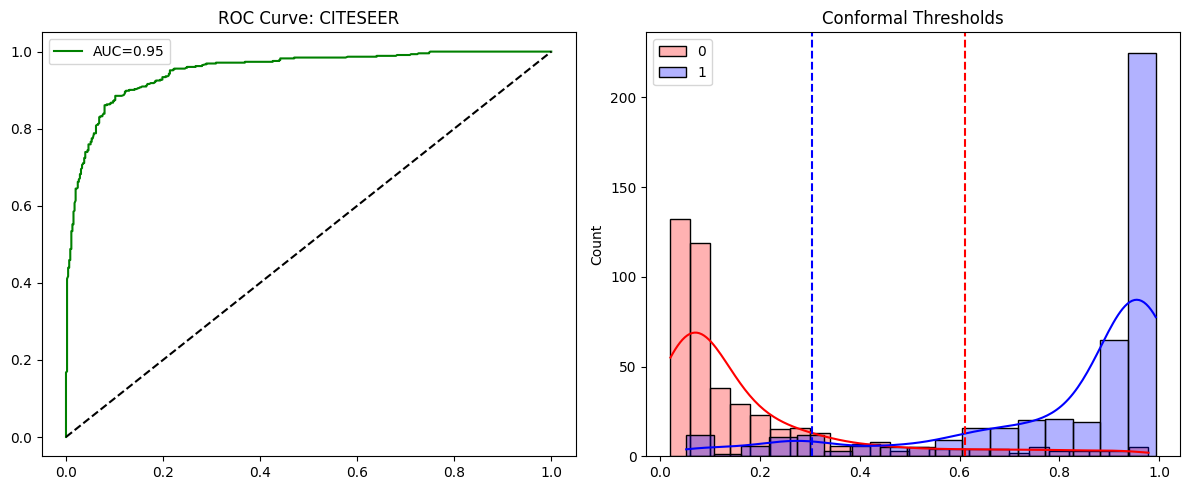

In [ ]:
res_cite = run_pipeline("citeseer/adjacency.tsv", pos_path=None, name="citeseer")


Running Pipeline (Scalable): OPENFLIGHTS
Computing SVD Embeddings (Rank 32)...
Sampling negatives and building features...
Training Gradient Boosting...
-> Thresholds: Accept 0 if p <= 0.262, Accept 1 if p >= 0.846

RESULTS (OPENFLIGHTS):
AUC: 0.9863
Base F1: 0.9520
Coverage: 0.9747 (Target: 0.9)
Abstention: 0.0728
Decided F1: 0.9722


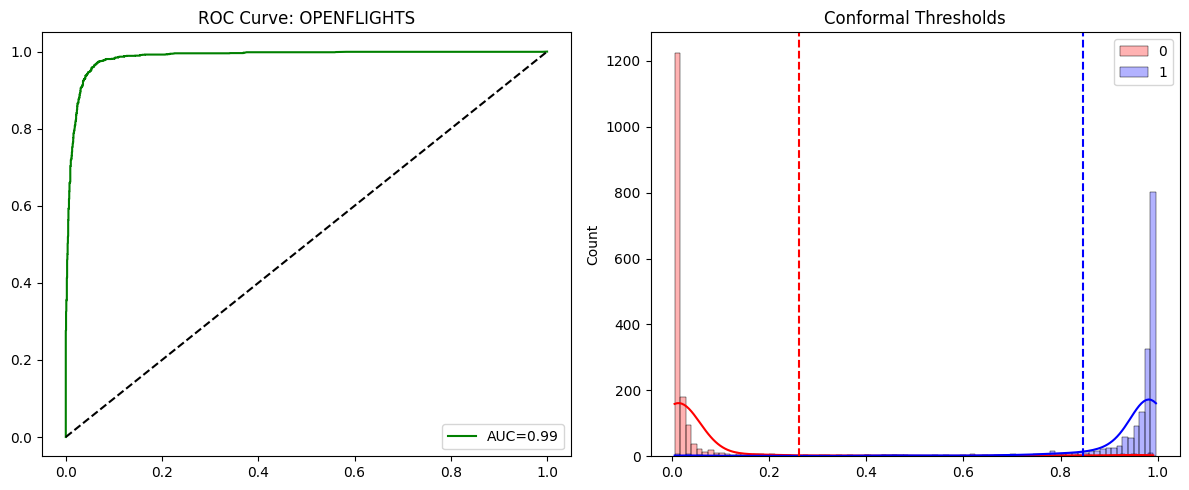

In [ ]:
res_flight = run_pipeline("openflights/adjacency.tsv", pos_path="openflights/position.tsv", name="openflights")